In [ ]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 # imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop, utils
from snntorch import functional as SF
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

from IPython.display import clear_output

In [ ]:
# dataloader arguments
batch_size = 128
beta = 0.5
num_steps = 50

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      res = net(data)
      spk_out, mem_out = res[0], res[-1]
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
def learn(net, train_loader, test_loader, num_steps=num_steps, device=device, num_epochs=25):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
    loss_fn = SF.ce_rate_loss()
    train_acc_hist = []
    test_acc_hist = []
    loss_hist = []

    print('device', device)

    # training loop
    for epoch in range(num_epochs):

        avg_loss = backprop.BPTT(net, train_loader, optimizer=optimizer, criterion=loss_fn,
                                num_steps=num_steps, time_var=False, device=device)
        loss_hist.append(avg_loss.detach().numpy())

        # Train set accuracy
        train_acc = batch_accuracy(train_loader, net, num_steps)
        train_acc_hist.append(train_acc)

        # Test set accuracy
        test_acc = batch_accuracy(test_loader, net, num_steps)
        test_acc_hist.append(test_acc)

        if (epoch + 1) % 5 == 0:
            clear_output()
            print(f"Epoch {epoch}, Train Loss: {avg_loss.item():.6f}")
            print(f"Epoch {epoch}, Train/Test Acc: {train_acc * 100:.2f}%/{test_acc * 100:.2f}%\n")
            # Plot Loss
            fig = plt.figure(facecolor="w", figsize=(10, 5))
            plt.plot(loss_hist)
            plt.plot([])
            plt.title("Loss Curves")
            plt.legend(["Train Loss", "Test Loss"])
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()

            fig = plt.figure(facecolor="w", figsize=(10, 5))
            plt.plot(train_acc_hist)
            plt.plot(test_acc_hist)
            plt.title("Acc Curves")
            plt.legend(["Train Acc", "Test Acc"])
            plt.xlabel("Iteration")
            plt.ylabel("Acc")
            plt.show()

In [ ]:
def test_net(net, train_loader, test_loader, num_steps):
    data, targets = next(iter(train_loader))
    spk_rec, mem_rec = forward_pass(net, num_steps, data)
    print(spk_rec.shape)
    test_acc = sum([batch_accuracy(test_loader, net, num_steps) for _ in range(10)]) / 10
    print(test_acc)

# Simple ThrData 
x>0.5 or x<0.5

In [ ]:
class ThrDataset(Dataset):
    def __init__(self, data, thr):
        self.data = data
        self.thr = thr

    def __getitem__(self, index):
        return torch.tensor([self.data[index]]).float(), int(self.data[index] > self.thr)

    def __len__(self):
        return len(self.data)

In [ ]:
train_data = np.random.uniform(size=1000)
test_data = np.random.uniform(size=1000)

train_dataset = ThrDataset(data=train_data, thr=0.5)
test_dataset =  ThrDataset(data=test_data, thr=0.5)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
data, targets = next(iter(train_loader))
data, targets

(tensor([[0.9383],
         [0.1032],
         [0.1512],
         [0.4332],
         [0.0037],
         [0.6511],
         [0.3202],
         [0.9096],
         [0.2626],
         [0.6797],
         [0.2379],
         [0.2758],
         [0.8011],
         [0.3164],
         [0.2533],
         [0.5924],
         [0.9366],
         [0.4525],
         [0.3066],
         [0.4969],
         [0.5602],
         [0.7562],
         [0.0275],
         [0.5335],
         [0.2795],
         [0.3211],
         [0.1171],
         [0.4888],
         [0.8851],
         [0.8743],
         [0.5823],
         [0.4859],
         [0.0351],
         [0.4743],
         [0.1015],
         [0.6942],
         [0.6792],
         [0.2573],
         [0.7243],
         [0.7206],
         [0.6282],
         [0.0953],
         [0.3883],
         [0.8660],
         [0.4575],
         [0.7578],
         [0.2495],
         [0.2473],
         [0.3776],
         [0.5208],
         [0.2471],
         [0.1742],
         [0.

## One neuron

Epoch 45, Train Loss: 0.422513
Epoch 45, Train/Test Acc: 99.55%/98.66%



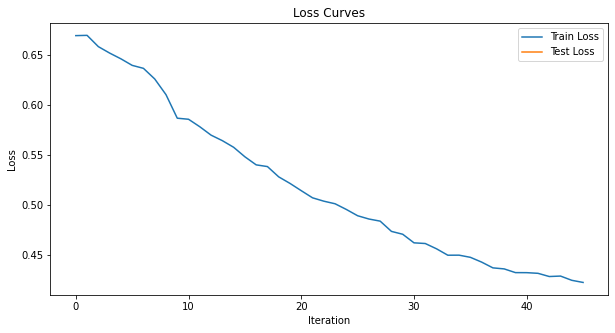

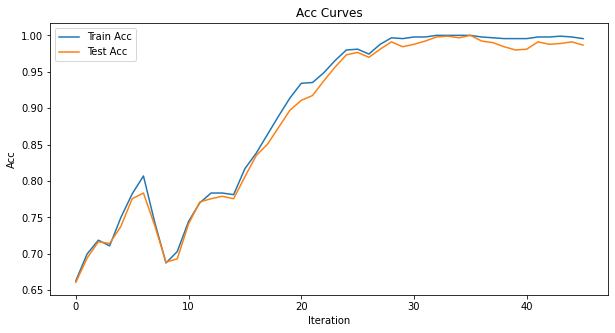

In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs=2):
        super().__init__()

        spike_grad = surrogate.fast_sigmoid(slope=25)

        self.lin = nn.Linear(num_inputs, num_outputs)
        self.lif = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

    def forward(self, x):
        return self.lif(self.lin(x.flatten(1)))

net = Net(num_inputs=1).to(device)
test_net(net, train_loader, test_loader, num_steps)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=50)

## One slstm

Epoch 45, Train Loss: 0.693147
Epoch 45, Train/Test Acc: 51.23%/51.79%



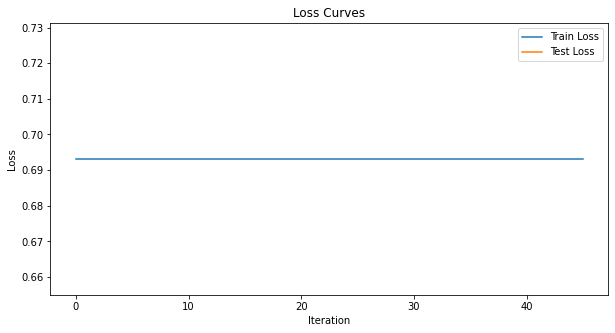

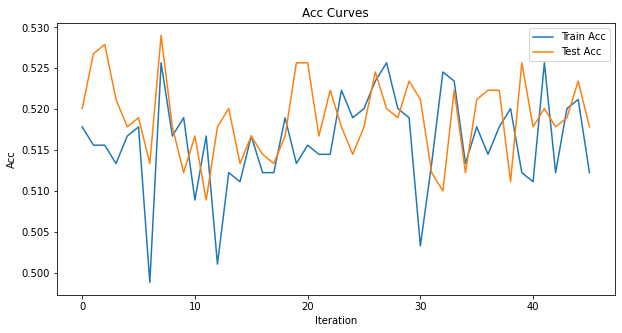

In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs=2):
        super().__init__()

        # num_hidden1 = 10

        spike_grad = surrogate.straight_through_estimator()
        # spike_grad = surrogate.fast_sigmoid(slope=25)

        self.slstm1 = snn.SLSTM(num_inputs, num_outputs, spike_grad=spike_grad, init_hidden=True, output=True)
        # self.slstm2 = snn.SLSTM(num_hidden1, num_outputs, spike_grad=spike_grad)

    def forward(self, x):
        return self.slstm1(x.flatten(1))

net = Net(num_inputs=1).to(device)
test_net(net, train_loader, test_loader, num_steps)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=50)

# WindowDataset
Up or Down

In [ ]:
window = 10

In [ ]:
class WindowDataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        return x, int(self.data[index+self.window] > x[-1])

    def __len__(self):
        return len(self.data) - self.window

In [ ]:
def plot_f():
    x = train_x
    y = f(x)
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(x, y)
    plt.show()

In [ ]:
def test_it(net, delim=3):
    skip = int(train_x.size / delim)
    x = train_x
    y = f(x)
    dataset = WindowDataset(data=y, window=window)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=True)
    res_up = []
    res_down = []
    right = 0
    all = 0
    for data, target in loader:
        res = net(data)
        output = res[0]
        _, idx = output.sum(dim=0).max(0)
        if idx == 1:
            res_up.append(float(data[0][-1]))
            res_down.append(float('nan'))
        else:
            res_up.append(float('nan'))
            res_down.append(float(data[0][-1]))
        right += int(idx == target)
        all += 1
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(x[skip:-skip], y[skip:-skip])
    plt.scatter(x[window - 1 + skip:-1 - skip], res_up[skip:-skip], marker='^', color='green')
    plt.scatter(x[window - 1 + skip:-1 - skip], res_down[skip:-skip], marker='v', color='red')
    plt.title("Plot sin")
    plt.show()
    print(f'Accuracy: {100 * right / all:.2f}%')

## sin

In [ ]:
def f_sin(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return torch.sin(x).float()

## sin 3x...


In [ ]:
def f_sin3x(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (0.5 * torch.sin(3 * x) + 0.5 * torch.sin(6 * x) + 1).float()

## sin with noise

In [ ]:
def f_sin_noise(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (f_sin3x(x) + 0.1 * torch.rand(x.size(0))).float()

## sin with trend

In [ ]:
def f_sin_trend(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (f_sin(x) + 0.001 * np.arange(x.size(0))).float()

## sin3x trend

In [ ]:
def f_sin3x_trend(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (f_sin3x(x) + 0.005 * np.arange(x.size(0))).float()

In [ ]:
f = f_sin3x_trend

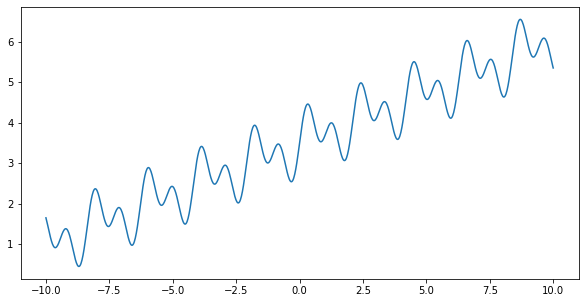

In [ ]:
train_x = np.linspace(-10, 10, 1000)
test_x = np.linspace(10, 30, 1000)
train_data = f(train_x)
test_data = f(test_x)

train_dataset = WindowDataset(data=train_data, window=window)
test_dataset =  WindowDataset(data=test_data, window=window)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
data, targets = next(iter(train_loader))  # test all ok
plot_f()

In [ ]:
# class Net(nn.Module):
#     def __init__(self, num_inputs, num_hidden=64, num_outputs=2):
#         super().__init__()

#         spike_grad = surrogate.fast_sigmoid(slope=25)

#         self.lin1 = nn.Linear(num_inputs, num_hidden)
#         self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)
#         self.lin2 = nn.Linear(num_hidden, num_outputs)
#         self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

#     def forward(self, x):
#         return self.lif2(self.lin2(self.lif1(self.lin1(x.flatten(1)))))

# net = Net(num_inputs=window).to(device)
# test_net(net, train_loader, test_loader, num_steps)
# learn(net, train_loader, test_loader, num_steps=40, num_epochs=200)
# test_it(net)

Epoch 49, Train Loss: 0.481776
Epoch 49, Train/Test Acc: 80.80%/82.70%



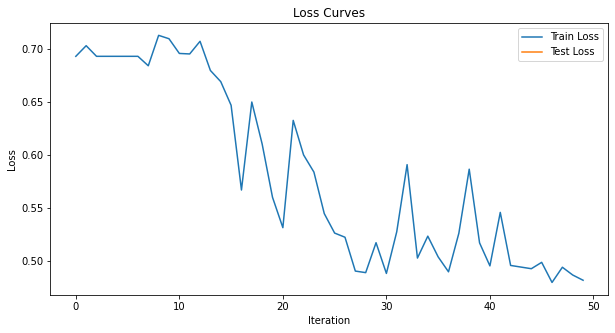

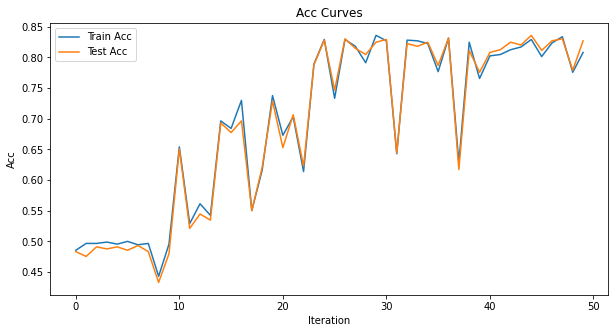

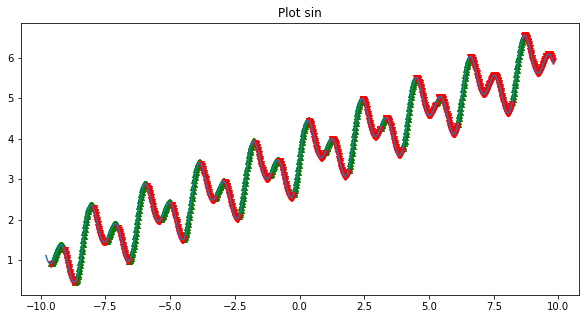

Accuracy: 81.31%


In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden=64, num_outputs=2):
        super().__init__()

        spike_grad = surrogate.fast_sigmoid(25)

        self.slstm1 = snn.SLSTM(num_inputs, num_hidden, spike_grad=spike_grad, threshold=0.5, reset_mechanism='subtract')
        self.slstm2 = snn.SLSTM(num_hidden, num_outputs, spike_grad=spike_grad, threshold=0.5, output=True, reset_mechanism='subtract')

    def forward(self, x):
        mem, syn = self.slstm1.init_slstm()
        out, mem, syn = self.slstm1(x.flatten(1), syn=syn, mem=mem)
        
        mem, syn = self.slstm2.init_slstm()
        out, mem, syn = self.slstm2(out, syn=syn, mem=mem)
        return out, mem, syn

net = Net(num_inputs=window).to(device)
test_net(net, train_loader, test_loader, num_steps)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=50)
test_it(net, 100)

Epoch 49, Train Loss: 0.340178
Epoch 49, Train/Test Acc: 97.77%/97.32%



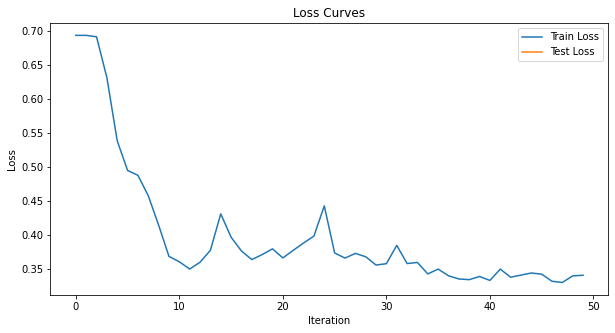

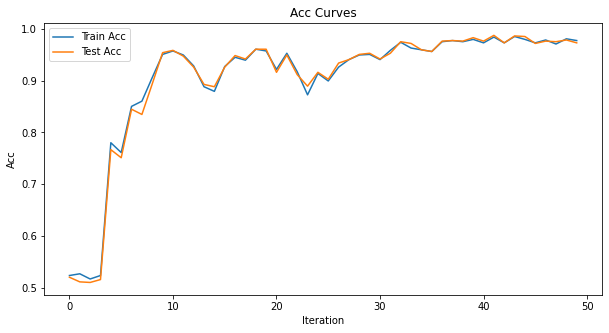

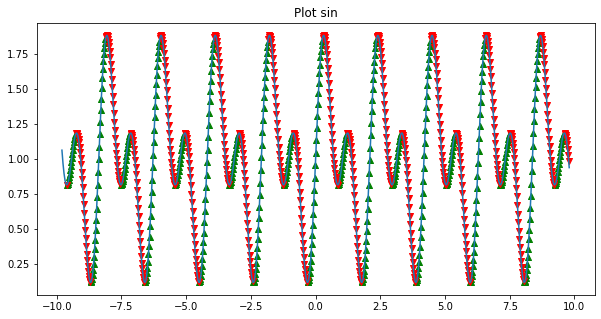

Accuracy: 97.88%


In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden=64, num_outputs=2):
        super().__init__()

        spike_grad = surrogate.fast_sigmoid(25)

        self.slstm1 = snn.SLSTM(num_inputs, num_hidden, spike_grad=spike_grad, threshold=0.5, reset_mechanism='subtract')
        self.slstm2 = snn.SLSTM(num_hidden, num_outputs, spike_grad=spike_grad, threshold=0.5, output=True, reset_mechanism='subtract')

    def forward(self, x):
        mem, syn = self.slstm1.init_slstm()
        out, mem, syn = self.slstm1(x.flatten(1), syn=syn, mem=mem)
        
        mem, syn = self.slstm2.init_slstm()
        out, mem, syn = self.slstm2(out, syn=syn, mem=mem)
        return out, mem, syn

net = Net(num_inputs=window).to(device)
test_net(net, train_loader, test_loader, num_steps)
learn(net, train_loader, test_loader, num_steps=40, num_epochs=50)
test_it(net, 100)

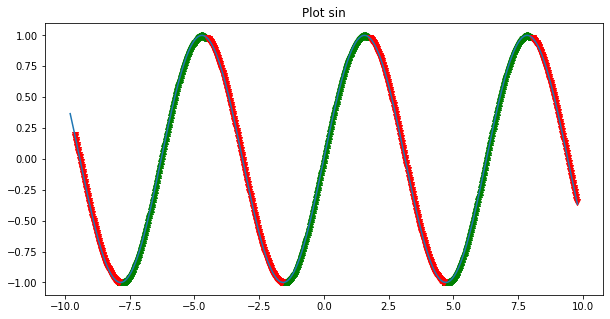

Accuracy: 96.46%


In [ ]:
test_it(net, 100)

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs=2):
        super().__init__()

        # num_hidden1 = 10

        # spike_grad_lstm = surrogate.straight_through_estimator()
        spike_grad = surrogate.fast_sigmoid(slope=25)

        self.lin = nn.Linear(num_inputs, num_outputs)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

        # initialize layers
        # self.slstm1 = snn.SLSTM(num_inputs, num_outputs, spike_grad=spike_grad, init_hidden=True, output=True)
        # self.slstm2 = snn.SLSTM(num_hidden1, num_outputs, spike_grad=spike_grad)

    def forward(self, x):
        # spk1, syn1, mem1 = self.slstm1(x.flatten(1))
        # spk2, syn2, mem2 = self.slstm2(spk1, syn2, mem2)
        return self.lif1(self.lin(x.flatten(1)))

        return spk1, syn1, mem1

# Load the network onto CUDA if available
net = Net(num_inputs=1).to(device)